In [1]:
# load model 
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd
import tensorflow as tf



In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
sys.path.append("..")

%matplotlib inline

import imagenet_stubs
import numpy as np
import keras
from tensorflow.keras.utils import load_img, img_to_array

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

^C


C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [9]:

import differential_evolution

In [2]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [3]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [4]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

Images saved successfully.


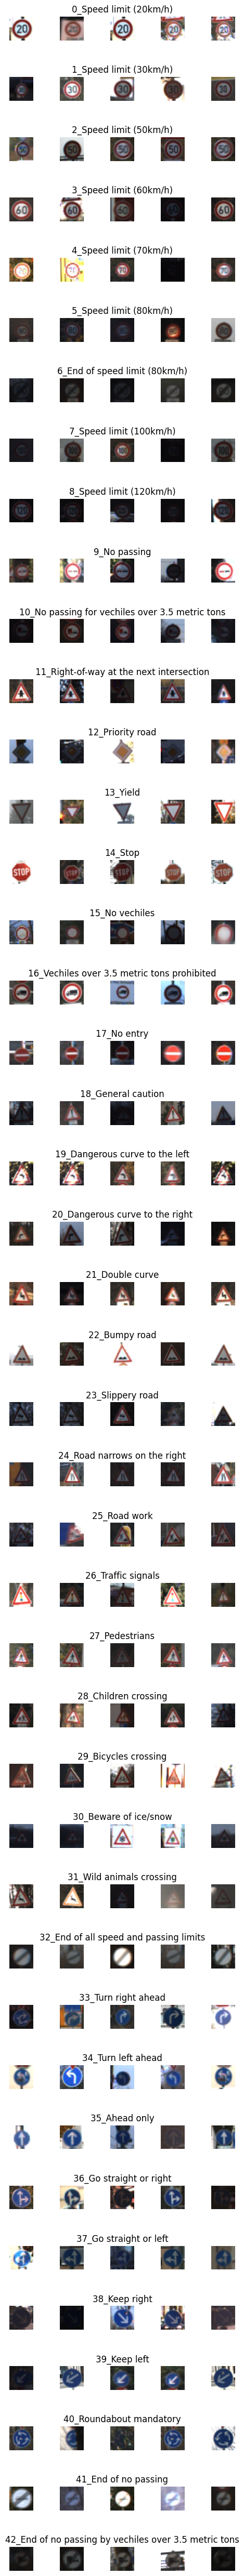

In [5]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

# make afolder that have the images of the signs and the classes as afolder



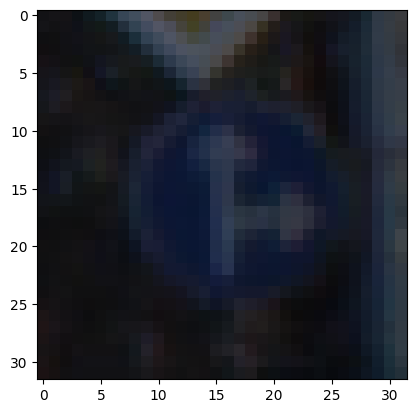

In [7]:
# print one image
plt.imshow(X_train[1000])

In [13]:
def grayscale(img):
    if len(img.shape) == 3:  # Check if the image is not already grayscale
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        image = img  # If already grayscale, no need to convert
    plt.axis('off')
    return image


(32, 32)


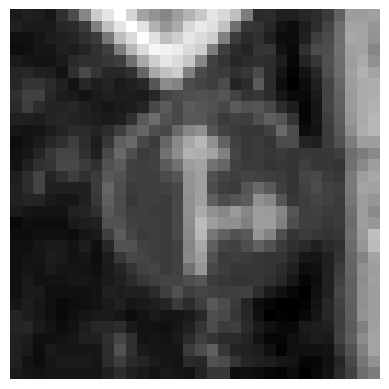

In [14]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [15]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [16]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

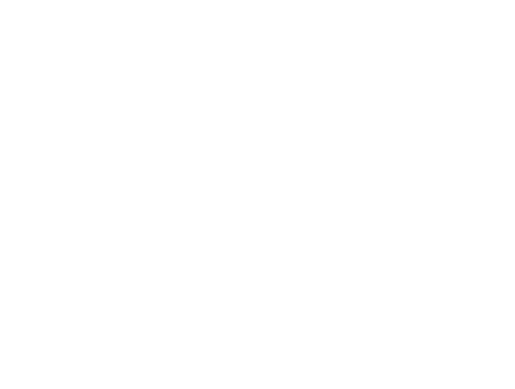

In [17]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(32, 32)


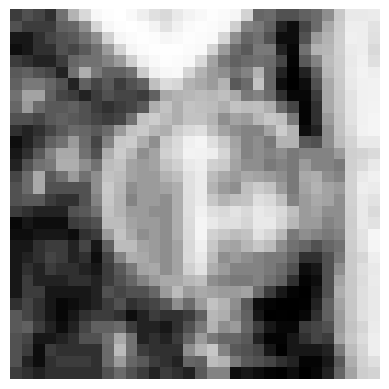

In [18]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [19]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

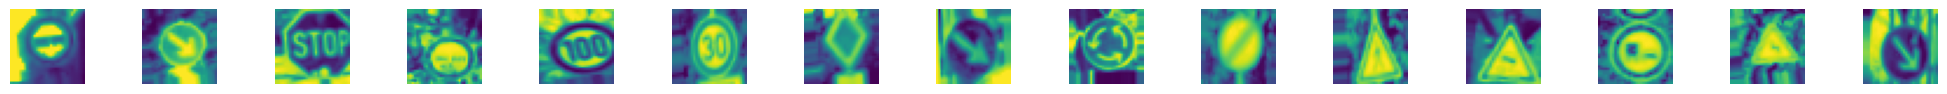

In [21]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [22]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [23]:
model = keras.models.load_model('traffic_sign_classifier.hdf5', compile=True)


In [24]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)
print('Test Loss: %.3f' % loss)

Test Accuracy: 0.959
Test Loss: 0.184


In [25]:
from art.estimators.classification import TensorFlowV2Classifier

loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(
    clip_values=(0, 1),
    model=model,
    nb_classes=10,
    input_shape=(32, 32, 1),  # Change this to match your model's input shape
    loss_object=loss_object,
)

C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mosta\AppData\Roaming\Python\Python310\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [21]:
x_test=X_test

array([[[0.89411765],
        [0.78039216],
        [0.83921569],
        ...,
        [0.38823529],
        [0.40392157],
        [0.35686275]],

       [[0.94901961],
        [0.89411765],
        [0.92941176],
        ...,
        [0.96078431],
        [0.92941176],
        [0.83921569]],

       [[0.92941176],
        [0.94901961],
        [0.89411765],
        ...,
        [0.98823529],
        [0.98823529],
        [0.97647059]],

       ...,

       [[0.71372549],
        [0.54117647],
        [0.58823529],
        ...,
        [0.71372549],
        [0.65490196],
        [0.83921569]],

       [[0.65490196],
        [0.58823529],
        [0.49411765],
        ...,
        [0.58823529],
        [0.65490196],
        [0.78039216]],

       [[0.58823529],
        [0.54117647],
        [0.58823529],
        ...,
        [0.71372549],
        [0.71372549],
        [0.83921569]]])

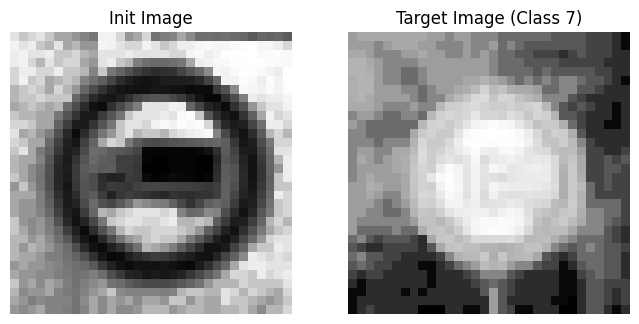

In [83]:
# Choose an index from the test set (or any other set)
init_image_index = 0  # Choose the index of the init image
target_class = 7  # Choose the target class (e.g., class 7)

# Get the init image and target image
init_image = X_test[init_image_index]
target_image_index = np.random.choice(np.where(y_test.argmax(axis=1) == target_class)[0])
target_image = X_test[target_image_index]

# Preprocess the images (assuming preprocessing function is defined)

init_image_processed = init_image
target_image_processed = target_image

# Display the init image and target image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(init_image_processed, cmap='gray')
plt.title('Init Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(target_image_processed, cmap='gray')
plt.title('Target Image (Class {})'.format(target_class))
plt.axis('off')

plt.show()


In [57]:
x_test[1][np.newaxis, :, :, :].shape

(1, 32, 32, 1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]

Adversarial image at step 0. L2 error 4.753584521113028e-07 and class label 7.


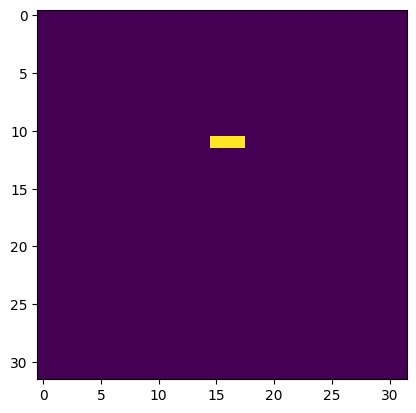

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]

Adversarial image at step 10. L2 error 4.753584521113028e-07 and class label 7.


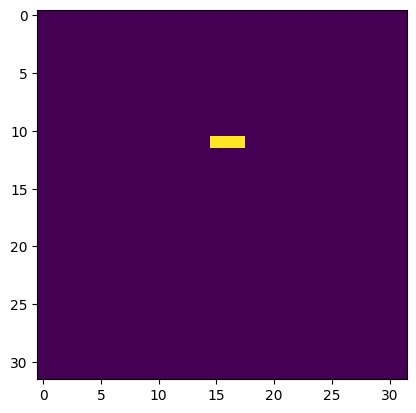

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]

Adversarial image at step 20. L2 error 4.753584521113028e-07 and class label 7.


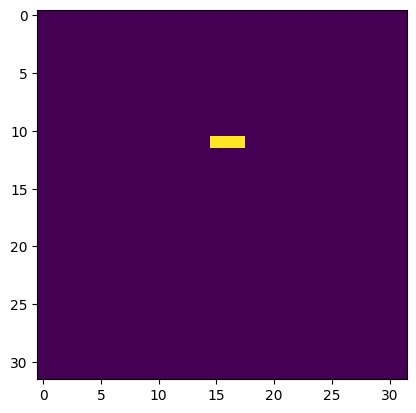

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 996.75it/s]


Adversarial image at step 30. L2 error 4.753584521113028e-07 and class label 7.


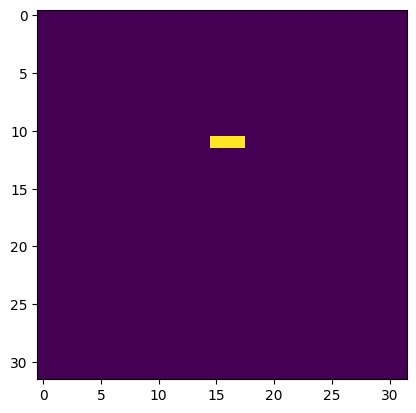

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 996.98it/s]


Adversarial image at step 40. L2 error 4.753584521113028e-07 and class label 7.


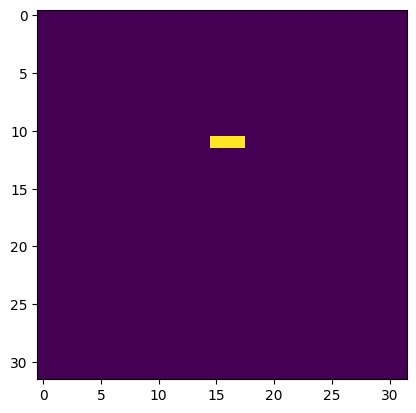

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]

Adversarial image at step 50. L2 error 4.753584521113028e-07 and class label 7.


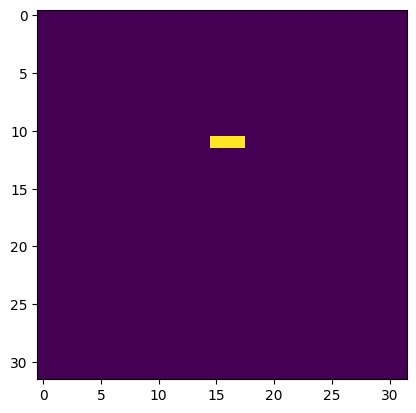

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]


Adversarial image at step 60. L2 error 4.753584521113028e-07 and class label 7.


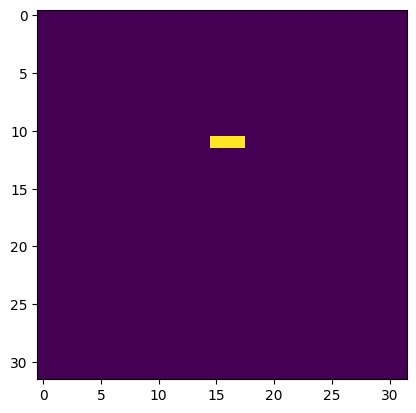

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]

Adversarial image at step 70. L2 error 4.753584521113028e-07 and class label 7.


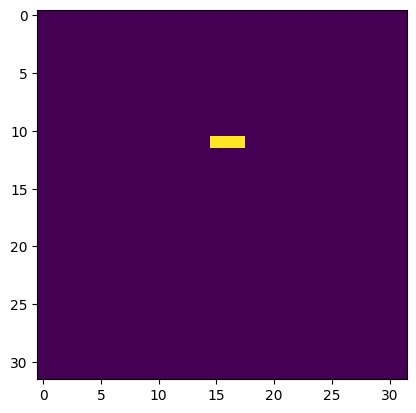

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 999.60it/s]

Adversarial image at step 80. L2 error 4.753584521113028e-07 and class label 7.


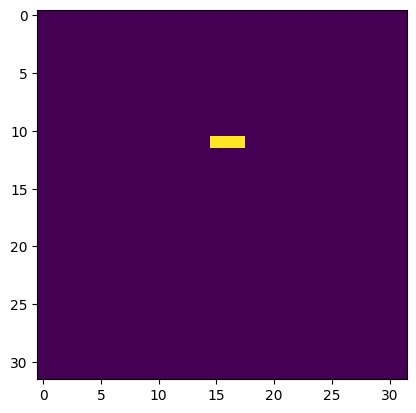

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]


Adversarial image at step 90. L2 error 4.753584521113028e-07 and class label 7.


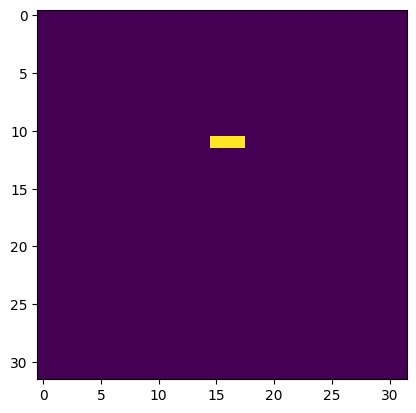

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]


Adversarial image at step 100. L2 error 4.753584521113028e-07 and class label 7.


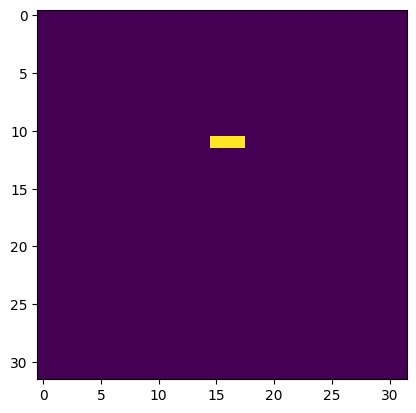

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 998.41it/s]

Adversarial image at step 110. L2 error 4.753584521113028e-07 and class label 7.


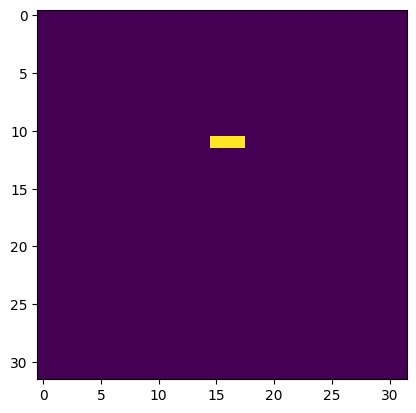

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]


Adversarial image at step 120. L2 error 4.753584521113028e-07 and class label 7.


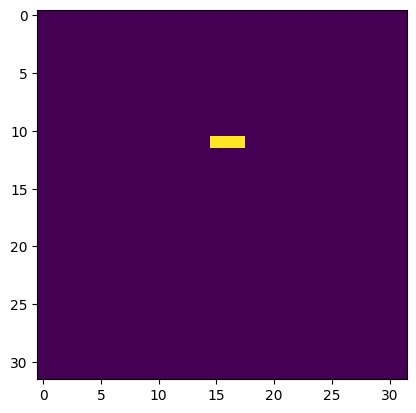

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 1014.83it/s]

Adversarial image at step 130. L2 error 4.753584521113028e-07 and class label 7.


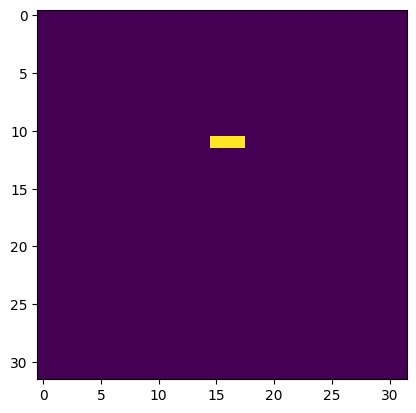

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Adversarial image at step 140. L2 error 4.753584521113028e-07 and class label 7.


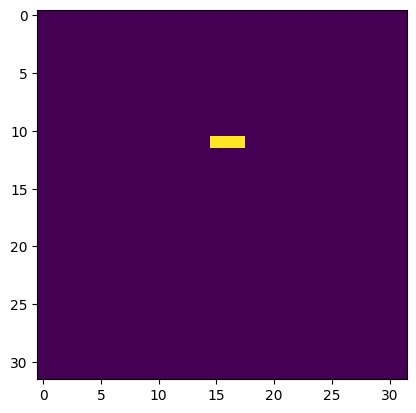

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Adversarial image at step 150. L2 error 4.753584521113028e-07 and class label 7.


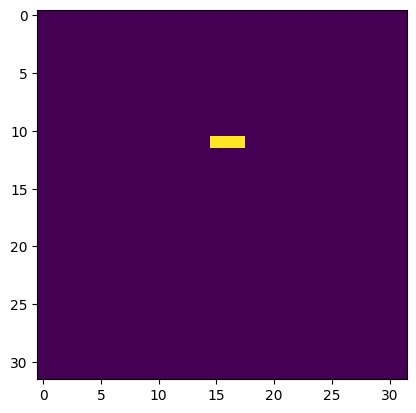

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]

Adversarial image at step 160. L2 error 4.753584521113028e-07 and class label 7.


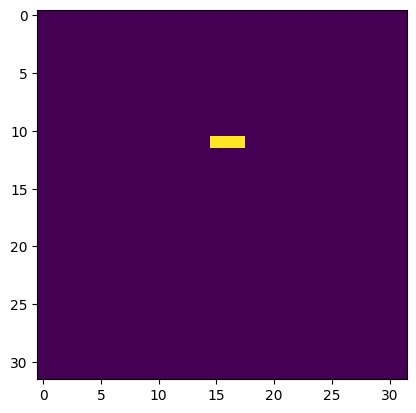

HopSkipJump: 100%|██████████| 1/1 [00:00<?, ?it/s]


Adversarial image at step 170. L2 error 4.753584521113028e-07 and class label 7.


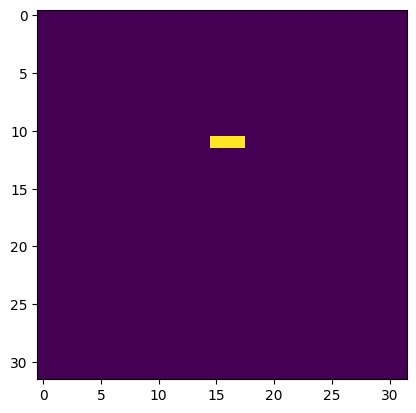

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 996.75it/s]


Adversarial image at step 180. L2 error 4.753584521113028e-07 and class label 7.


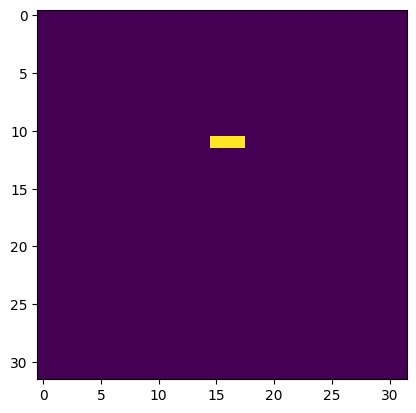

HopSkipJump: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Adversarial image at step 190. L2 error 4.753584521113028e-07 and class label 7.


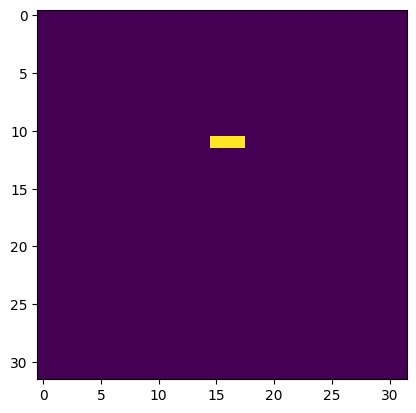

In [85]:


from art.attacks.evasion import HopSkipJump

print(y_test[0], y_test[1])



attack = HopSkipJump(classifier=classifier, targeted=True, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([init_image_processed])
for i in range(20):
    x_adv = attack.generate(x=np.array([target_image]), y=to_categorical([7], 10), x_adv_init=x_adv, resume=True)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0].astype(np.uint))
    plt.show(block=False)
    
    attack.max_iter = iter_step

Now we can modify the pixels of any image we want.

Let's modify our = image by making pixel (32,32) yellow.

(12630, 43)

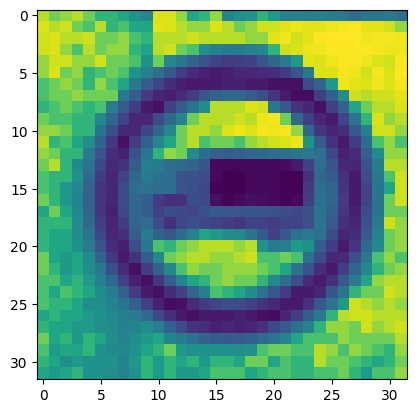

In [59]:
plt.imshow( X_test[0])
y_test.shape

 22061056/553467096 [>.............................] - ETA: 2:40

KeyboardInterrupt: 